# Simple Walk 2D continuous

base environment on https://github.com/nicknochnack/ReinforcementLearningCourse/blob/main/Project%203%20-%20Custom%20Environment.ipynb

continuous state space environment

action space: BOX in two directions from -1 to 1

state space: box with shape(2,1)?

goal reached when distance closer than 1





## 1. Import Dependencies

In [86]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

import matplotlib.pyplot as plt

# logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


In [87]:
class SimpleWalk2Dcont(Env):
    """simple walk environment in 2D with a continuous action and state space"""
    def __init__(self):
        self.x_min = 0.0
        self.x_max = 10.0
        self.max_steps = 15
        self.action_space = Box(low=-1.0, high=1.0, shape=(2, ))
        self.observation_space = Box(low=self.x_min, high=self.x_max, shape=(4, )) # x,y position, x,y goal
        self.state = np.ndarray(shape=(4,), dtype=np.float32)
        # safe past states in an array, safe x and y positions
        
    def __out_of_bounds(self):
        """check if the current state is out of bounds"""
        position = self.state[0:2]
        for element in position:
            if not (self.x_min <= element <= self.x_max):
                
                return True
            else:
                return False
            
    def __append_state(self):
        self.state_array[0].append(self.state[0])
        self.state_array[1].append(self.state[1])
        
    def __distance_to_goal(self):
        distance_to_goal = np.linalg.norm(self.state[0:2] - self.state[2:4])
        return distance_to_goal     
        
    
    def step(self, action):
        previouse_state = self.state
        # update position
        self.state[0] += action[0] # update x
        self.state[1] += action[1] # update y
        self.__append_state()
        new_state = self.state
        self.steps_taken += 1
        distance_to_goal = self.__distance_to_goal()
    
        if self.steps_taken >= self.max_steps:
            # maximum number of steps reached
            logging.debug("maximum number of steps reached")
            reward = -100.0
            done = True
        elif self.__out_of_bounds():
            # went out of bounds
            logging.debug("out of bounds")
            reward = -100.0
            done = True
        elif distance_to_goal < 1:
            # reached goal
            reward = 1000.0
            logging.debug("reached goal")
            done = True
        elif False: # self.distance_to_goal > distance_to_goal:
            # got closer
            logging.debug("got closer")
            reward = (self.distance_to_goal - distance_to_goal) * 20
            done = False
        else:
            
            movement = self.distance_to_goal - distance_to_goal
            logging.debug("movement: {}".format(movement))
            reward = movement * 50
            done = False
        
        # update distance to goal
        self.distance_to_goal = distance_to_goal
        info = {'distance_to_goal': self.distance_to_goal, 
                'steps_taken': self.steps_taken,
                'previous_state': previouse_state,
                'new_state': new_state}
        
        return self.state, reward, done, info
    
    def reset(self):
        """reset and initalize the environment"""
        
        self.state = np.random.uniform(self.x_min, self.x_max, (4,))
        self.state_array = [[], []] # x, y
        self.__append_state()
        self.steps_taken = 0
        self.distance_to_goal = self.__distance_to_goal()
        return self.state
    
    def render(self):
        
        logging.debug("visited states: ", self.state_array)
        logging.debug("x: {}".format(self.state_array[0]))
        logging.debug("y: {}".format(self.state_array[1]))
        goal = self.state[2:4]
        logging.debug("goal: {}".format(goal))
        
        
        # plot
        fig, ax = plt.subplots()

        # plot the visited states
        ax.plot(self.state_array[0], self.state_array[1], linewidth=2.0)
        
        # plot the goal
        ax.plot(goal[0], goal[1], 'ro')
        circle1 = plt.Circle((goal[0], goal[1]), 1, color='r', fill=False)
        ax.add_patch(circle1)
        ax.set(
            xlim=(self.x_min, self.x_max), #xticks=np.arange(1, 8),
            ylim=(self.x_min, self.x_max), #yticks=np.arange(1, 8))
            )
        plt.show()
        
    

    
env = SimpleWalk2Dcont()

print(env.action_space.sample())
print(env.observation_space.sample())

[-0.19424771 -0.3058057 ]
[1.8990952 5.6156616 4.4460144 9.989469 ]


In [88]:
a= [5.450801, 3.7648005, 0.2729502, 8.326116,]
a[2:4]

[0.2729502, 8.326116]

## Check Environment

### random walk

DEBUG:root:out of bounds
DEBUG:root:Steps taken: 1
DEBUG:root:distance to goal: 8.569750581419186
INFO:root:Episode:1 Score:-100.0
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module>
    runpy.run_module(module, run_name="__main__", alter_sys=Fa

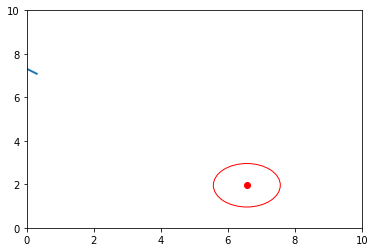

In [89]:
env = SimpleWalk2Dcont()
episodes = 1
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        # env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        logging.debug('Steps taken: {}'.format(info['steps_taken']))
        logging.debug('distance to goal: {}'.format(info['distance_to_goal']))
        score+=reward
    logging.info('Episode:{} Score:{}'.format(episode, score))
    env.render()
env.close()

### env_checker

In [90]:
from stable_baselines3.common import env_checker
env_checker.check_env(env)

DEBUG:root:movement: -0.05772284851027276
DEBUG:root:movement: 0.38266844473460626
DEBUG:root:movement: -0.5479191137027177
DEBUG:root:movement: 0.21857149391852992
DEBUG:root:movement: 0.6499418258170895
DEBUG:root:movement: 0.7479588643779911
DEBUG:root:movement: -0.595674966824359
DEBUG:root:movement: 0.35645350316985613
DEBUG:root:movement: -1.2510103610719137
DEBUG:root:movement: -0.06061490812965076
DEBUG:root:movement: -0.03354594006931588


## Callback

In [91]:
# create callback fun

import os
from stable_baselines3.common.callbacks import BaseCallback

class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

env_name = 'Walk2Dcont'

CHECKPOINT_DIR = './train/train_' + env_name
LOG_DIR = './train/log_' + env_name

callback = TrainAndLoggingCallback(check_freq=10_000, save_path=CHECKPOINT_DIR)

## Train

In [92]:
log_path = os.path.join('Training', 'Logs')

In [93]:
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1, 
    tensorboard_log=log_path,
    learning_rate=0.001,
    n_steps =256
    )
logger.setLevel(logging.INFO)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [94]:
model.learn(
    total_timesteps=15_000, 
    callback = callback
    )

Logging to Training\Logs\PPO_29
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.5     |
|    ep_rew_mean     | 48       |
| time/              |          |
|    fps             | 531      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12.3        |
|    ep_rew_mean          | 35          |
| time/                   |             |
|    fps                  | 398         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 512         |
| train/                  |             |
|    approx_kl            | 0.032385945 |
|    clip_fraction        | 0.213       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.81       |
|    explained_variance   | 0.000334    

In [95]:
model.save('PPO')
logger.setLevel(logging.DEBUG)

## Test Model

DEBUG:root:movement: 1.3129723010364782
DEBUG:root:movement: 1.153422911356956
DEBUG:root:movement: 0.7237441673088314
DEBUG:root:reached goal
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module>
    runpy.run_module(module, run_name="__main__", 

info {'distance_to_goal': 0.3346917302767697, 'steps_taken': 4, 'previous_state': array([4.81517819, 6.03415755, 4.54004281, 5.84358191]), 'new_state': array([4.81517819, 6.03415755, 4.54004281, 5.84358191])}


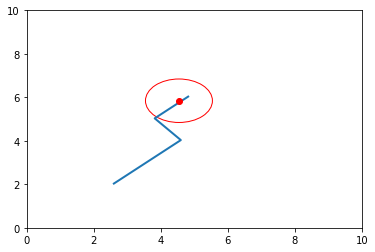

In [96]:
# test prediction
env = SimpleWalk2Dcont()
env.reset()

while True:
    action, _states = model.predict(env.state)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
env.render()


DEBUG:root:reached goal
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 1083, in emit
    msg = self.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 927, in format
    return fmt.format(record)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 663, in format
    record.message = record.getMessage()
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\logging\__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\Users\Luttk\.vscode-insiders\extensions\ms-toolsai.jupyter-2022.1.1001614873\pythonFiles\vscode_datascience_helpers\kernel_prewarm_starter.py", line 31, in <module>
    runpy.run_module(module, run_name="__main__", alter_sys=False)
  File "C:\Users\Luttk\anaconda3\envs\rl-test\lib\runpy.py", line 213, in run_module
    return _run_c

info {'distance_to_goal': 0.8043907138542064, 'steps_taken': 1, 'previous_state': array([3.37227503, 5.30724212, 3.5015543 , 4.51330806]), 'new_state': array([3.37227503, 5.30724212, 3.5015543 , 4.51330806])}


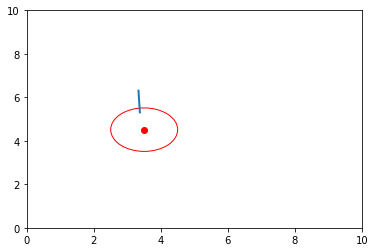

In [97]:
# test prediction
env = SimpleWalk2Dcont()
env.reset()

while True:
    action, _states = model.predict(env.state)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
env.render()


In [98]:
evaluate_policy(model, env, n_eval_episodes=10, render=False)

C:\Users\Luttk\anaconda3\envs\rl-test\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
DEBUG:root:movement: 1.3149361696381003
DEBUG:root:movement: 1.1402056115874664
DEBUG:root:reached goal
DEBUG:root:movement: 1.3848253869789175
DEBUG:root:reached goal
DEBUG:root:movement: 1.410940509912525
DEBUG:root:reached goal
DEBUG:root:movement: 1.0181663744093994
DEBUG:root:movement: 0.9955217065657989
DEBUG:root:movement: 0.994696306159609
DEBUG:root:movement: 0.9998530936975776
DEBUG:root:movement: 1.0040174567961029
DEBUG:root:movement: 1.00463103373436
DEBUG:root:reached goal
DEBUG:root:movement: 1.1876366815195003
DEBUG:root:movement: 1.0095046985459082
DEBUG:root:reached goal
DEBUG:root:movement: 1.404349290524990

(1150.8579151153565, 74.37905720605531)

INFO:root:Episode:1 Score:1230.2365099081233


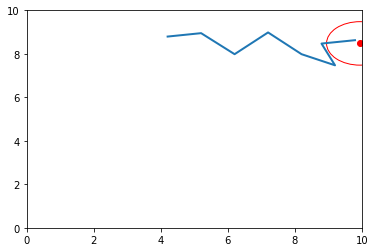

INFO:root:Episode:2 Score:1113.517648746919


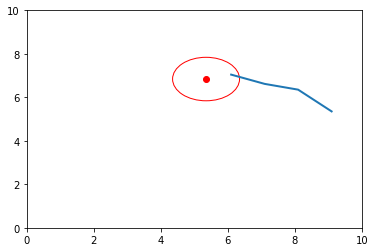

INFO:root:Episode:3 Score:1288.7902995640338


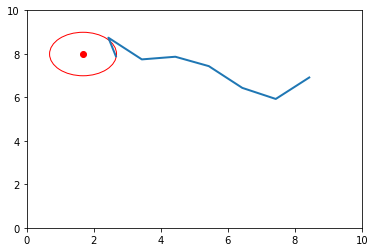

INFO:root:Episode:4 Score:1424.1899591495894


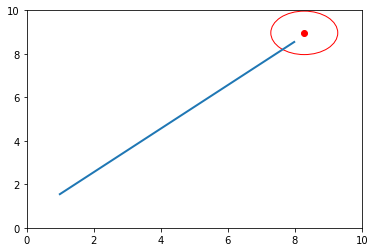

INFO:root:Episode:5 Score:189.68195745428164


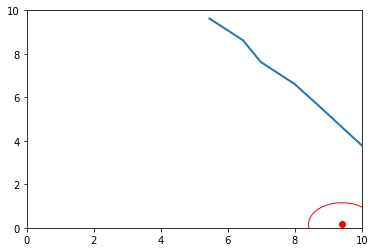

INFO:root:Episode:6 Score:1279.4283508606168


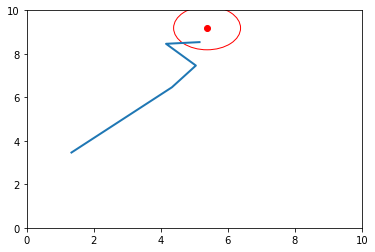

INFO:root:Episode:7 Score:1141.0978505086414


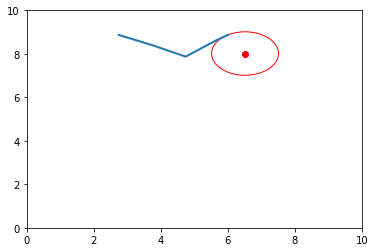

INFO:root:Episode:8 Score:1102.2728273280159


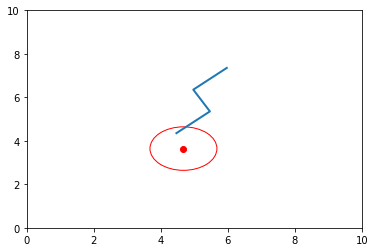

INFO:root:Episode:9 Score:1212.5892814847482


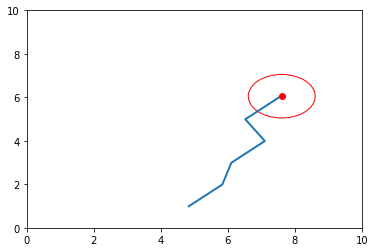

INFO:root:Episode:10 Score:1272.8554798055893


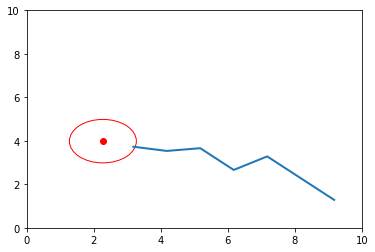

In [99]:
logger.setLevel(logging.INFO)
env = SimpleWalk2Dcont()
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        # env.render()
        action, _state = model.predict(state)
        n_state, reward, done, info = env.step(action)
        logging.debug('Steps taken: {}'.format(info['steps_taken']))
        logging.debug('distance to goal: {}'.format(info['distance_to_goal']))
        score+=reward
    logging.info('Episode:{} Score:{}'.format(episode, score))
    env.render()
env.close()

## Remarks

PPO_26

training looks stable till step 80k 

training sufficient after 15k

## TODO

```shell
C:\Users\Luttk\anaconda3\envs\rl-test\lib\site-packages\stable_baselines3\common\env_checker.py:130: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
```